In [1]:
## Import the modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Other Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,confusion_matrix
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

## ML Models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:

from google.colab import drive
drive.mount('/content/gdrive')
     

Mounted at /content/gdrive


In [3]:
df= pd.read_csv("/content/gdrive/MyDrive/Fraud_data/Fraud_Detection.csv")
print(df.shape)

(99776, 31)


all attributes except for Time and Amount are scaled. So we need to scale the time and amount

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

In [5]:
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

- Understanding data

In [6]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.51 % of the dataset
Frauds 0.49 % of the dataset


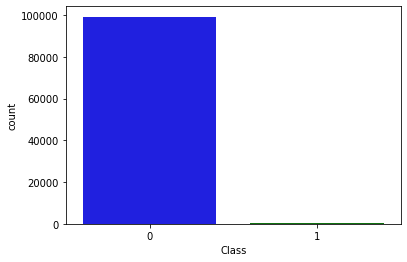

In [7]:
## A visual representation of the above information
sns.countplot('Class',data=df,palette=['blue','green'])

In [8]:
df.describe(include='all')

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
count,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,...,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000
mean,-0.270695,-0.024058,0.657125,0.173522,-0.283754,0.091063,-0.121257,0.052796,-0.052008,-0.037262,...,-0.108665,-0.036607,0.008733,0.131621,0.026571,0.000296,0.002010,0.004931,0.882000,-0.077924
std,1.890413,1.678539,1.406177,1.372090,1.379589,1.304693,1.299613,1.268675,1.133966,1.136929,...,0.641080,0.638218,0.595000,0.442029,0.494770,0.400861,0.325992,0.070048,3.253856,0.783361
min,-56.407510,-72.715728,-33.680984,-5.172595,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,...,-10.933144,-44.807735,-2.836627,-10.295397,-2.534330,-9.390980,-9.617915,0.000000,-0.322941,-1.982150
25%,-1.031193,-0.597659,0.172367,-0.708895,-0.900604,-0.650199,-0.602878,-0.137719,-0.702465,-0.499784,...,-0.531342,-0.176572,-0.324092,-0.132378,-0.325209,-0.062601,-0.005376,0.000000,-0.230514,-0.483757
50%,-0.262837,0.079598,0.750652,0.196889,-0.314849,-0.158707,-0.070383,0.074152,-0.120310,-0.095873,...,-0.083665,-0.049238,0.064647,0.169859,-0.070415,0.009919,0.023352,0.000000,0.000000,0.000000
75%,1.152963,0.740262,1.374722,1.039248,0.250214,0.485321,0.414467,0.361241,0.557531,0.437705,...,0.309041,0.081874,0.406041,0.419740,0.300823,0.083486,0.076950,0.000000,0.769486,0.516243
max,2.132386,22.057729,4.226108,16.715537,34.801666,22.529298,36.677268,20.007208,10.392889,13.249433,...,10.503090,19.002942,4.014444,5.541598,3.517346,12.152401,33.847808,1.000000,240.950288,5.648134


In [9]:
scores = pd.DataFrame(columns=['Model', 'Train_F1_Score', 
                               'Test_F1_Score'])

def get_metrics(train_actual, train_predicted, test_actual, test_predicted, model_description, dataframe):
    train_f1score   = f1_score(train_actual, train_predicted, average="weighted")
    test_f1score    = f1_score(test_actual, test_predicted, average="weighted")

    dataframe       = dataframe.append(pd.Series([model_description, train_f1score,
                                                  test_f1score],
                                                 index=scores.columns ), 
                                       ignore_index=True)

    return(dataframe)

In [10]:
scores

,Model,Train_F1_Score,Test_F1_Score


In [11]:
classifiers={'DT': DecisionTreeClassifier(),
'KNN': KNeighborsClassifier(),
'RF': RandomForestClassifier(),
'GBM':GradientBoostingClassifier()}


In [12]:
## Making a single train test split and applying multiple models
X = df.drop('Class', axis=1)
y = df['Class']


# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

In [13]:
%%time
from sklearn.metrics import confusion_matrix
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred_train= classifier.predict(X_train)
    y_pred_test=classifier.predict(X_test)
    
    print(classification_report(y_train, y_pred_train))#digits
    print("\n")
    print(classification_report(y_test, y_pred_test))
    print("\n")
    print(confusion_matrix(y_train, y_pred_train))
    print(confusion_matrix(y_test, y_pred_test))
    
    scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, classifier.__class__.__name__, scores)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69499
           1       1.00      1.00      1.00       344

    accuracy                           1.00     69843
   macro avg       1.00      1.00      1.00     69843
weighted avg       1.00      1.00      1.00     69843



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29785
           1       0.89      0.91      0.90       148

    accuracy                           1.00     29933
   macro avg       0.94      0.96      0.95     29933
weighted avg       1.00      1.00      1.00     29933



[[69499     0]
 [    0   344]]
[[29768    17]
 [   13   135]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69499
           1       0.99      0.86      0.92       344

    accuracy                           1.00     69843
   macro avg       0.99      0.93      0.96     69843
weighted

In [14]:

scores

,Model,Train_F1_Score,Test_F1_Score
0,DecisionTreeClassifier,1.000000,0.999004
1,KNeighborsClassifier,0.999215,0.999027
2,RandomForestClassifier,1.000000,0.999596
3,GradientBoostingClassifier,1.000000,0.999099


In [15]:
pd.set_option('display.max_columns',None)
df.groupby(['Class']).median()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.256258,0.075790,0.756234,0.188732,-0.312874,-0.155814,-0.067831,0.073412,-0.116305,-0.093690,0.177925,0.114471,-0.007628,0.07992,0.300030,0.068608,-0.000202,-0.085559,-0.027319,-0.024729,-0.058015,-0.084088,-0.049193,0.065023,0.170118,-0.070763,0.009674,0.023283,0.001105,-0.001702
1,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,-4.578825,3.586218,-5.502530,-0.065566,-6.72972,-0.057227,-3.549795,-5.302949,-1.664346,0.646807,0.284693,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,-0.209402,1.402739


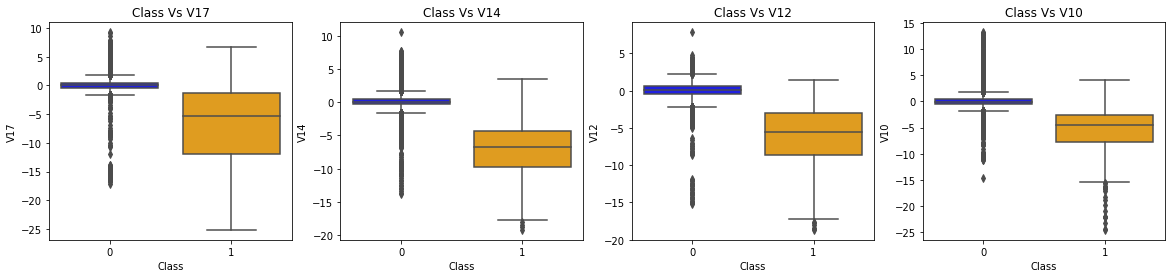

In [16]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors=['blue','orange']
sns.boxplot(x="Class", y="V17", data=df, palette=colors, ax=axes[0])
axes[0].set_title('Class Vs V17')

sns.boxplot(x="Class", y="V14", data=df, palette=colors, ax=axes[1])
axes[1].set_title('Class Vs V14')


sns.boxplot(x="Class", y="V12", data=df, palette=colors, ax=axes[2])
axes[2].set_title('Class Vs V12')


sns.boxplot(x="Class", y="V10", data=df, palette=colors, ax=axes[3])
axes[3].set_title('Class Vs V10')

plt.show()

Based on the box plots there are some extreme values. Here we use a
technique called clipping for handling such values. For variables v12,
v14, v17 and v10, identify the extreme values in class==1, and then we
clip any value which is IQR less than q1 or IQR greater than q3 to q1-
IQR or q3+IQR respectively

In [17]:
df1=df
fraud_out= df1['V12'].loc[df1['Class']==1].values
q75, q25 = np.percentile(fraud_out,q=75), np.percentile(fraud_out,q=25)
iqr=q75-q25
lower, upper=q25- iqr, q75 + iqr
df1['V12']=df1['V12'].clip(lower=lower)

fraud_out= df1['V14'].loc[df1['Class']==1].values
q75, q25 = np.percentile(fraud_out,q=75), np.percentile(fraud_out,q=25)
iqr=q75-q25
lower, upper=q25- iqr, q75 + iqr
df1['V14']=df1['V14'].clip(lower=lower)

fraud_out= df1['V17'].loc[df1['Class']==1].values
q75, q25 = np.percentile(fraud_out,q=75), np.percentile(fraud_out,q=25)
iqr=q75-q25
lower, upper=q25- iqr, q75 + iqr
df1['V17']=df1['V17'].clip(lower=lower)

fraud_out= df1['V10'].loc[df1['Class']==1].values
q75, q25 = np.percentile(fraud_out,q=75), np.percentile(fraud_out,q=25)
iqr=q75-q25
lower, upper=q25- iqr, q75 + iqr
df1['V10']=df1['V10'].clip(lower=lower)

         

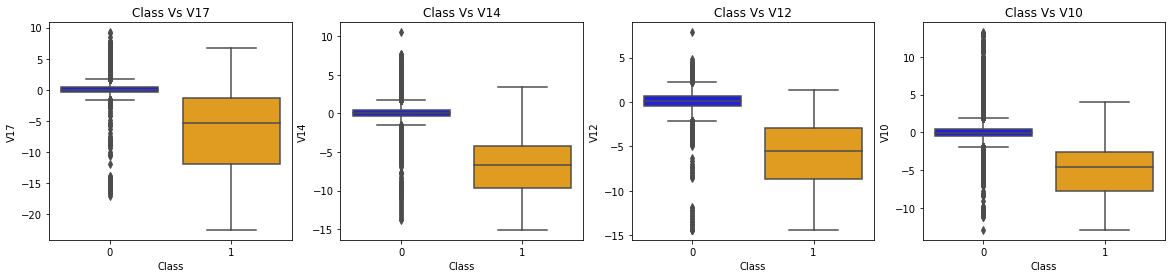

In [18]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors=['blue','orange']
sns.boxplot(x="Class", y="V17", data=df, palette=colors, ax=axes[0])
axes[0].set_title('Class Vs V17')

sns.boxplot(x="Class", y="V14", data=df, palette=colors, ax=axes[1])
axes[1].set_title('Class Vs V14')


sns.boxplot(x="Class", y="V12", data=df, palette=colors, ax=axes[2])
axes[2].set_title('Class Vs V12')


sns.boxplot(x="Class", y="V10", data=df, palette=colors, ax=axes[3])
axes[3].set_title('Class Vs V10')

plt.show()

Using this clipped data, splitting to train and test models

In [19]:
X = df1.drop('Class', axis=1)
y = df1['Class']


# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [20]:
scores

,Model,Train_F1_Score,Test_F1_Score
0,DecisionTreeClassifier,1.000000,0.999004
1,KNeighborsClassifier,0.999215,0.999027
2,RandomForestClassifier,1.000000,0.999596
3,GradientBoostingClassifier,1.000000,0.999099


As there is a heavy class imbalance in the data. To work with imbalance data, we can undersample the majority
class to reduce the imbalance. In doing so, we may be training models
with fewer records so we need to check how the model performs on entire data

In [21]:

# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:fraud_df.shape[0]]

df_undersample = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = df_undersample.sample(frac=1, random_state=42)

new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
77081,-0.802798,0.681598,1.660549,0.436262,0.826050,0.004548,0.247156,0.206164,-1.118345,-0.434499,1.596486,0.785453,0.698135,-0.199801,1.033542,-0.052998,0.299812,0.101426,1.049735,0.278386,-0.129360,-0.490497,-0.104207,-0.325355,-0.023987,0.305610,0.045089,0.080805,0,-0.273966,0.565593
99566,-1.360293,-0.458069,-0.700404,2.737229,-1.005106,2.891399,5.802537,-1.933197,-1.017717,1.987862,0.504116,-0.863431,-0.184450,-1.016916,-1.559410,1.154313,-2.043858,-0.151699,-0.943514,-1.493401,-0.936990,-0.053812,0.580106,0.216927,0.151643,-0.332115,-0.469800,-1.495006,1,9.857616,1.954334
42687,-0.773912,1.475797,0.337472,1.030453,0.643364,0.714093,0.528513,-0.173457,0.448327,1.611376,-1.391142,-0.948328,-0.281275,-0.134247,2.118792,-0.588884,-0.237467,0.275459,1.331360,0.450062,0.017563,0.426284,-0.211251,-1.329818,-0.165445,-0.071527,-0.100023,0.065115,0,-0.187922,-0.136751
99757,-2.783865,1.596824,-2.084844,2.512986,-1.446749,-0.828496,-0.732262,-0.203329,-0.347046,-2.162061,1.966123,-3.127456,0.506574,-5.926131,0.931091,-2.499307,-3.712752,-1.142133,0.626241,-0.515001,0.203563,0.293268,0.199568,0.146868,0.163602,-0.624085,-1.333100,0.428634,1,1.591874,5.195507
99685,0.951025,3.252926,-5.039105,4.632411,3.014501,-1.349570,0.980940,-1.819539,-2.099049,-1.347557,2.680578,-1.462945,-0.705397,-7.445296,-0.561332,3.139656,5.665429,3.790316,-1.909799,-0.381444,1.404524,-0.760549,0.358292,-1.185942,-1.286177,0.000365,0.169662,0.108276,1,-0.313490,4.301900


In [22]:
new_df.shape

(984, 31)

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


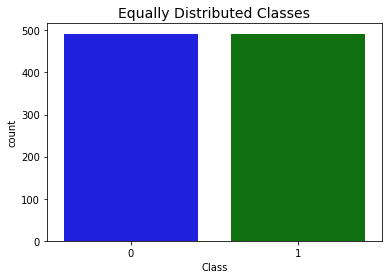

In [23]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts(normalize=True))



sns.countplot('Class', data=new_df, palette=['blue','green'])
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

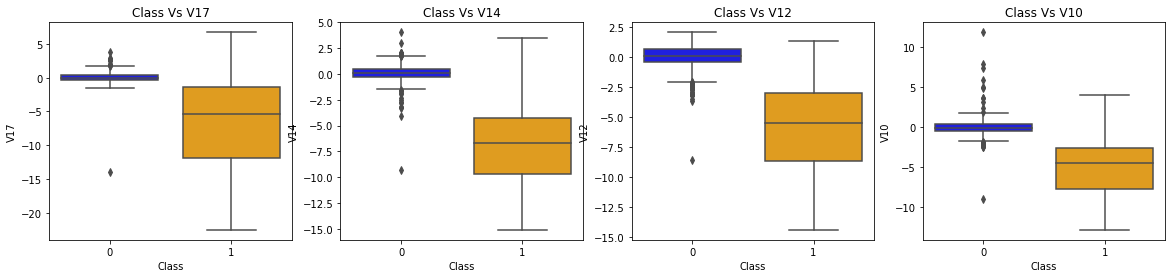

In [24]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors=['blue','orange']
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('Class Vs V17')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('Class Vs V14')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('Class Vs V12')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('Class Vs V10')

plt.show()

In [25]:
## There are some extreme values in the records, we can go with quantile clipping

fraud_out= new_df['V12'].loc[new_df['Class']==1].values
q75, q25 = np.percentile(fraud_out,q=75), np.percentile(fraud_out,q=25)
iqr=q75-q25
lower, upper=q25- iqr, q75 + iqr
new_df['V12']=new_df['V12'].clip(lower=lower)

fraud_out= new_df['V14'].loc[new_df['Class']==1].values
q75, q25 = np.percentile(fraud_out,q=75), np.percentile(fraud_out,q=25)
iqr=q75-q25
lower, upper=q25- iqr, q75 + iqr
new_df['V14']=new_df['V14'].clip(lower=lower)

fraud_out= new_df['V17'].loc[new_df['Class']==1].values
q75, q25 = np.percentile(fraud_out,q=75), np.percentile(fraud_out,q=25)
iqr=q75-q25
lower, upper=q25- iqr, q75 + iqr
new_df['V17']=new_df['V17'].clip(lower=lower)

fraud_out= new_df['V10'].loc[new_df['Class']==1].values
q75, q25 = np.percentile(fraud_out,q=75), np.percentile(fraud_out,q=25)
iqr=q75-q25
lower, upper=q25- iqr, q75 + iqr
new_df['V10']=new_df['V10'].clip(lower=lower)
         

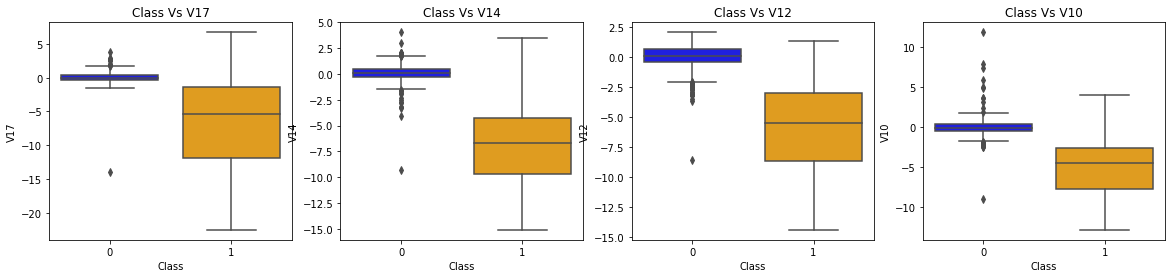

In [26]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors=['blue','orange']
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('Class Vs V17')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('Class Vs V14')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('Class Vs V12')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('Class Vs V10')

plt.show()

In [27]:
## Making a single train test split and applying multiple models
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(787, 30)
(197, 30)
(787,)
(197,)


In [29]:
# Let's implement simple classifiers
# Classifier Libraries
from sklearn.svm import SVC

classifiers = {
    "RandomForest": RandomForestClassifier(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "Adaboost": AdaBoostClassifier(),
    "Gradboost": GradientBoostingClassifier()
}

In [30]:
%%time
class_metric={}
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train) #787 records model built
    training_score = cross_val_score(classifier, X_train, y_train, cv=5,scoring='f1')
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "%  F1 score")
    pred= classifier.predict(X_test) # 197 records test
    f1= f1_score(y_test,pred)
    class_metric[classifier.__class__.__name__]=f1
print("F1 Score on test data is: ",class_metric)

Classifiers:  RandomForestClassifier Has a training score of 97.0 %  F1 score
Classifiers:  KNeighborsClassifier Has a training score of 95.0 %  F1 score
Classifiers:  SVC Has a training score of 96.0 %  F1 score
Classifiers:  DecisionTreeClassifier Has a training score of 94.0 %  F1 score
Classifiers:  AdaBoostClassifier Has a training score of 96.0 %  F1 score
Classifiers:  GradientBoostingClassifier Has a training score of 97.0 %  F1 score
F1 Score on test data is:  {'RandomForestClassifier': 0.9671361502347418, 'KNeighborsClassifier': 0.9423076923076923, 'SVC': 0.9423076923076923, 'DecisionTreeClassifier': 0.9769585253456221, 'AdaBoostClassifier': 0.9722222222222223, 'GradientBoostingClassifier': 0.9722222222222223}
CPU times: user 5.45 s, sys: 171 ms, total: 5.62 s
Wall time: 5.51 s


In [31]:
### The result obtained is from the undersampled data. Lets check how the model performs on unseen data

test1= df.drop(X_train.index) ## minus 787 records 
print(test1.shape)
#print(test1.head(5))

(98989, 31)


In [32]:
clf= GradientBoostingClassifier()
clf.fit(X_train, y_train) #trained on 787 records
test=test1.drop('Class',axis=1)
confusion_matrix(test1.loc[:,'Class'],clf.predict(test)) ## testing on 98989

array([[97674,  1205],
       [    5,   105]])

In [33]:
print(f1_score(test1.loc[:,'Class'],clf.predict(test)))
print(classification_report(test1.loc[:,'Class'],clf.predict(test)))

0.14788732394366197
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     98879
           1       0.08      0.95      0.15       110

    accuracy                           0.99     98989
   macro avg       0.54      0.97      0.57     98989
weighted avg       1.00      0.99      0.99     98989



We got a good result but this might not be reliable as we have undersampled the data before the model training. In order to not bias/ influence the
result, under sampling of train should be done within the cross validation
loop but not like undersampling and then crossvalidation

In [34]:
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [35]:
print(df.shape)

(99776, 31)


We need to do a stratified kfold of 5 splits of the data: 5 trains 5 test
At each step 1 train data taken, undersampled, built the model and
test it on test data. This process repeats 5 times since k=5 her

In [36]:
%%time
X = df.drop('Class', axis=1)
y = df['Class']
for train_index, test_index in sss.split(X, y):
    print("Train:", train_index.shape, "Test:", test_index.shape)

Train: (79820,) Test: (19956,)
Train: (79821,) Test: (19955,)
Train: (79821,) Test: (19955,)
Train: (79821,) Test: (19955,)
Train: (79821,) Test: (19955,)
CPU times: user 22.1 ms, sys: 978 µs, total: 23.1 ms
Wall time: 20.7 ms


In [37]:
from imblearn.under_sampling import NearMiss

In [38]:
%%time
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
for train, test in sss.split(X,y):
    print("train samples are", X.iloc[train].shape, " and test samples are",X.iloc[test].shape)
    X_nearmiss, y_nearmiss = NearMiss(sampling_strategy=1/10).fit_resample(X.iloc[train], y.iloc[train])
    print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
    print(X_nearmiss.shape, y_nearmiss.shape)
    DecisionTreeClassifier().fit(X_nearmiss, y_nearmiss)
    pred_test=clf.predict(X.iloc[test])
    print(len(pred_test),y.iloc[test].shape)
    print(confusion_matrix(y.iloc[test],pred_test))
    print(classification_report(y.iloc[test],pred_test))
    print("\n")
   
    

train samples are (79820, 30)  and test samples are (19956, 30)
NearMiss Label Distribution: Counter({0: 3930, 1: 393})
(4323, 30) (4323,)
19956 (19956,)
[[19619   238]
 [    1    98]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19857
           1       0.29      0.99      0.45        99

    accuracy                           0.99     19956
   macro avg       0.65      0.99      0.72     19956
weighted avg       1.00      0.99      0.99     19956



train samples are (79821, 30)  and test samples are (19955, 30)
NearMiss Label Distribution: Counter({0: 3940, 1: 394})
(4334, 30) (4334,)
19955 (19955,)
[[19616   241]
 [    1    97]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19857
           1       0.29      0.99      0.44        98

    accuracy                           0.99     19955
   macro avg       0.64      0.99      0.72     19955
weighted avg       1.00      

In [39]:
for train, test in sss.split(X,y):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy=1/10), DecisionTreeClassifier()) 
    undersample_model = undersample_pipeline.fit(X.iloc[train],y.iloc[train])
    undersample_prediction = undersample_model.predict(X.iloc[test])
    print(f1_score(y.iloc[test],undersample_prediction ))
    print(classification_report(y.iloc[test],undersample_prediction ))
    
    

0.02266556486837445
              precision    recall  f1-score   support

           0       1.00      0.58      0.74     19857
           1       0.01      0.97      0.02        99

    accuracy                           0.59     19956
   macro avg       0.51      0.78      0.38     19956
weighted avg       0.99      0.59      0.73     19956

0.02004339291249096
              precision    recall  f1-score   support

           0       1.00      0.52      0.69     19857
           1       0.01      0.99      0.02        98

    accuracy                           0.52     19955
   macro avg       0.51      0.76      0.35     19955
weighted avg       1.00      0.52      0.68     19955

0.02008158142453718
              precision    recall  f1-score   support

           0       1.00      0.53      0.69     19857
           1       0.01      0.98      0.02        98

    accuracy                           0.53     19955
   macro avg       0.50      0.75      0.36     19955
weighted avg  

Oversampling (increasing the majority class): In this case, we are increasing the number of minority class records and then train the models.
Use the SMOTE function and apply it under cross validation and get the result

In [40]:
for train, test in sss.split(X,y):
    print("train samples are", X.iloc[train].shape, " and test samples are",X.iloc[test].shape)
    X_smote, y_smote = SMOTE().fit_resample(X.iloc[train], y.iloc[train])
    print('SMOTE Label Distribution: {}'.format(Counter(y_smote)))
    print(X_smote.shape, y_smote.shape)

train samples are (79820, 30)  and test samples are (19956, 30)
SMOTE Label Distribution: Counter({1: 79427, 0: 79427})
(158854, 30) (158854,)
train samples are (79821, 30)  and test samples are (19955, 30)
SMOTE Label Distribution: Counter({0: 79427, 1: 79427})
(158854, 30) (158854,)
train samples are (79821, 30)  and test samples are (19955, 30)
SMOTE Label Distribution: Counter({0: 79427, 1: 79427})
(158854, 30) (158854,)
train samples are (79821, 30)  and test samples are (19955, 30)
SMOTE Label Distribution: Counter({0: 79427, 1: 79427})
(158854, 30) (158854,)
train samples are (79821, 30)  and test samples are (19955, 30)
SMOTE Label Distribution: Counter({0: 79428, 1: 79428})
(158856, 30) (158856,)


In [41]:
%%time
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
for train, test in sss.split(X,y):
    print("train samples are", X.iloc[train].shape, " and test samples are",X.iloc[test].shape)
    undersample_pipeline = imbalanced_make_pipeline(SMOTE(1/1), clf) 
    undersample_model = undersample_pipeline.fit(X.iloc[train], y.iloc[train])
    undersample_prediction = undersample_model.predict(X.iloc[test])
    print(f1_score(y.iloc[test],undersample_prediction ))
    print(classification_report(y.iloc[test],undersample_prediction ))
    print(confusion_matrix(y.iloc[test],undersample_prediction))

train samples are (79820, 30)  and test samples are (19956, 30)
0.6081081081081081
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19857
           1       0.46      0.91      0.61        99

    accuracy                           0.99     19956
   macro avg       0.73      0.95      0.80     19956
weighted avg       1.00      0.99      1.00     19956

[[19750   107]
 [    9    90]]
train samples are (79821, 30)  and test samples are (19955, 30)
0.6233766233766234
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19857
           1       0.46      0.98      0.62        98

    accuracy                           0.99     19955
   macro avg       0.73      0.99      0.81     19955
weighted avg       1.00      0.99      1.00     19955

[[19743   114]
 [    2    96]]
train samples are (79821, 30)  and test samples are (19955, 30)
0.6178343949044586
              precision    recall  